In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import pandas as pd
import numpy as np
import pickle
from natsort import natsorted

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
sns.set(style='ticks', context='notebook', font_scale=1.2)

In [2]:
def rm_duplicate_mols(mols):
    smiles = list(set([Chem.MolToSmiles(m, canonical=True) for m in mols]))
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    return mols


def protect_CBr(m):
    while m.HasSubstructMatch(Chem.MolFromSmarts('cCBr')):
        smarts = "[*:1]CBr>>[*:1]C[At]"
        rxn = AllChem.ReactionFromSmarts(smarts)
        ps = rxn.RunReactants((m,))
        products = rm_duplicate_mols([m[0] for m in ps])
        m = products[0]
    return m


def deprotect_CBr(m):
    while m.HasSubstructMatch(Chem.MolFromSmarts('C[At]')):
        smarts = "[*:1]C[At]>>[*:1]CBr"
        rxn = AllChem.ReactionFromSmarts(smarts)
        ps = rxn.RunReactants((m,))
        products = rm_duplicate_mols([m[0] for m in ps])
        m = products[0]
    return m


def rm_termini(m):
    
    # rm all Br
    m = protect_CBr(m)
    while m.HasSubstructMatch(Chem.MolFromSmarts('cBr')):
        smarts = "[*:1]Br>>[*:1]"
        rxn = AllChem.ReactionFromSmarts(smarts)
        ps = rxn.RunReactants((m,))
        products = rm_duplicate_mols([m[0] for m in ps])
        m = products[0]
    m = deprotect_CBr(m)
    
    # rm all BOO
    while m.HasSubstructMatch(Chem.MolFromSmarts('[B](-O)(-O)')):
        smarts = "[*:1]([B](-O)(-O))>>[*:1]"
        rxn = AllChem.ReactionFromSmarts(smarts)
        ps = rxn.RunReactants((m,))
        products = rm_duplicate_mols([m[0] for m in ps])
        m = products[0]
        
    return m

In [3]:
df = pd.read_csv('dataset.csv')
df

,poly_id,poly_type,comp,fracA,fracB,EA (eV),IP (eV),EA vs SHE (eV),IP vs SHE (eV),monoA,monoB
0,0_0,alternating,4A_4B,0.50,0.50,1.878902,6.261997,-3.406210,1.808017,OB(O)c1cc(F)c(B(O)O)cc1F,Oc1cc(O)c(Br)c(O)c1Br
1,0_0,block,4A_4B,0.50,0.50,2.329229,6.210397,-2.991909,1.761062,OB(O)c1cc(F)c(B(O)O)cc1F,Oc1cc(O)c(Br)c(O)c1Br
2,0_0,random,4A_4B,0.50,0.50,2.106772,6.272161,-3.196570,1.817267,OB(O)c1cc(F)c(B(O)O)cc1F,Oc1cc(O)c(Br)c(O)c1Br
3,0_1,alternating,4A_4B,0.50,0.50,2.893603,7.170897,-2.472685,2.635116,OB(O)c1cc(F)c(B(O)O)cc1F,N#Cc1cc(Br)c(F)cc1Br
4,0_1,block,4A_4B,0.50,0.50,2.896976,7.142086,-2.469582,2.608899,OB(O)c1cc(F)c(B(O)O)cc1F,N#Cc1cc(Br)c(F)cc1Br
...,...,...,...,...,...,...,...,...,...,...,...
42961,8_679,random,2A_6B,0.25,0.75,4.095619,7.057488,-1.366831,2.531914,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21,O=[N+]([O-])c1ncc(Br)cc1Br
42962,8_680,block,2A_6B,0.25,0.75,2.554801,5.874810,-2.784383,1.455677,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21,CC(Oc1ccc(Br)cc1Br)C(=O)NN
42963,8_680,random,2A_6B,0.25,0.75,2.470584,5.948941,-2.861863,1.523136,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21,CC(Oc1ccc(Br)cc1Br)C(=O)NN
42964,8_681,block,2A_6B,0.25,0.75,2.438739,5.308416,-2.891160,0.940259,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21,Nc1cc(Br)ccc1Br


In [5]:
def inflate_poly_type_difference(df, n=5):
    """
    Given a stoichioetric ratio (comp) and the monomers (poly_id), 
    inflate variance due to chain architecture (poly_type)
    """
    poly_ids = natsorted(list(set(df.loc[:, 'poly_id'])))
    
    for comp in ['4A_4B', '6A_2B', '2A_6B']:
        for poly_id in poly_ids:
            mask0 = df.loc[:, 'comp'] == comp
            mask1 = df.loc[:, 'poly_id'] == poly_id
            mask = np.logical_and(mask0, mask1)
            assert sum(mask) == 3 or sum(mask) == 2
        
            # ==
            # EA
            # ==
            mean = df.loc[mask, 'EA vs SHE (eV)'].mean() 
            stdd = df.loc[mask, 'EA vs SHE (eV)'].std() 
            # map to standardized scale
            ea_norm = (df.loc[mask, 'EA vs SHE (eV)'] - mean) / stdd
            # inflate
            ea_norm = ea_norm * n
            # map back to original scale
            ea = (ea_norm * stdd) + mean
            
            # ==
            # IP
            # ==
            mean = df.loc[mask, 'IP vs SHE (eV)'].mean() 
            stdd = df.loc[mask, 'IP vs SHE (eV)'].std() 
            # map to standardized scale
            ip_norm = (df.loc[mask, 'IP vs SHE (eV)'] - mean) / stdd
            # inflate
            ip_norm = ip_norm * n
            # map back to original scale
            ip = (ip_norm * stdd) + mean
        
            df.loc[mask, f'EA vs SHE (eV) poly_type_x{n}'] = list(ea)
            df.loc[mask, f'IP vs SHE (eV) poly_type_x{n}'] = list(ip)
    
    return df


def inflate_stoich_difference(df, n=5):
    """
    Given a chain architecture (poly_type) and the monomers (poly_id), 
    inflate variance due to stoichioetric ratio (comp)
    """
    poly_ids = natsorted(list(set(df.loc[:, 'poly_id'])))
    
    for poly_id in poly_ids:
        for poly_type in ['alternating', 'block', 'random']:  
            mask0 = df.loc[:, 'poly_type'] == poly_type
            mask1 = df.loc[:, 'poly_id'] == poly_id
            mask = np.logical_and(mask0, mask1)
            
            # alternating only has comp == 4A_4B
            if poly_type == 'alternating':
                df.loc[mask, f'EA vs SHE (eV) comp_x{n}'] = df.loc[mask, 'EA vs SHE (eV)']
                df.loc[mask, f'IP vs SHE (eV) comp_x{n}'] = df.loc[mask, 'IP vs SHE (eV)']
            else:
                assert sum(mask) == 3 or sum(mask) == 2
        
                # ==
                # EA
                # ==
                mean = df.loc[mask, 'EA vs SHE (eV)'].mean() 
                stdd = df.loc[mask, 'EA vs SHE (eV)'].std() 
                # map to standardized scale
                ea_norm = (df.loc[mask, 'EA vs SHE (eV)'] - mean) / stdd
                # inflate
                ea_norm = ea_norm * n
                # map back to original scale
                ea = (ea_norm * stdd) + mean
            
                # ==
                # IP
                # ==
                mean = df.loc[mask, 'IP vs SHE (eV)'].mean() 
                stdd = df.loc[mask, 'IP vs SHE (eV)'].std() 
                # map to standardized scale
                ip_norm = (df.loc[mask, 'IP vs SHE (eV)'] - mean) / stdd
                # inflate
                ip_norm = ip_norm * n
                # map back to original scale
                ip = (ip_norm * stdd) + mean
        
                df.loc[mask, f'EA vs SHE (eV) comp_x{n}'] = list(ea)
                df.loc[mask, f'IP vs SHE (eV) comp_x{n}'] = list(ip)
    
    return df

In [6]:
df = inflate_poly_type_difference(df, n=5)
df = inflate_stoich_difference(df, n=5)

<AxesSubplot:xlabel='EA vs SHE (eV)', ylabel='Density'>

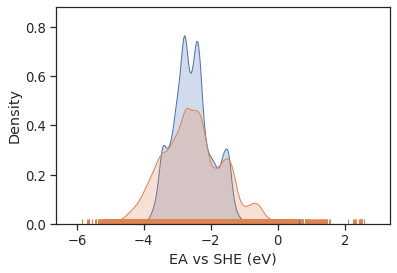

In [7]:
sns.kdeplot(df.loc[:, 'EA vs SHE (eV)'], fill=True)
sns.rugplot(df.loc[:, 'EA vs SHE (eV)'])
sns.kdeplot(df.loc[:, 'EA vs SHE (eV) comp_x5'], fill=True)
sns.rugplot(df.loc[:, 'EA vs SHE (eV) comp_x5'])

In [8]:
def make_master_chemprop_input(smiA, smiB):
    mA = Chem.MolFromSmiles(smiA)
    mB = Chem.MolFromSmiles(smiB)
    mA = rm_termini(mA)
    mB = rm_termini(mB)
    smiA = Chem.MolToSmiles(mA, canonical=True)
    smiB = Chem.MolToSmiles(mB, canonical=True)
    smiles = f'{smiA}.{smiB}'
    return smiles

def make_poly_chemprop_input(smiA, smiB, poly_type, fracA=0.5, selfedges=True):
    mA = Chem.MolFromSmiles(smiA)
    mB = Chem.MolFromSmiles(smiB)
    
    # replace BOO in monoA with R1 and R2
    m = mA
    for i in [1,2]:
        smarts = f"[*:1]([B](-O)(-O))>>[*:1]-[*{i}]"
        rxn = AllChem.ReactionFromSmarts(smarts)
        ps = rxn.RunReactants((m,))
        products = rm_duplicate_mols([m[0] for m in ps])
        m = products[0]
    
    smiA = Chem.MolToSmiles(m, canonical=True)
    smiA = smiA.replace('1*', '*:1').replace('2*', '*:2')
    
    # replace Br in monoB with R3 and R4
    m = mB
    m = protect_CBr(m)
    for i in [3,4]:
        smarts = f"[*:1]Br>>[*:1]-[*{i}]"
        rxn = AllChem.ReactionFromSmarts(smarts)
        ps = rxn.RunReactants((m,))
        products = rm_duplicate_mols([m[0] for m in ps])
        m = products[0]
    m = deprotect_CBr(m)
    
    smiB = Chem.MolToSmiles(m, canonical=True)
    smiB = smiB.replace('3*', '*:3').replace('4*', '*:4')
    
    # join smiles
    smiles = f'{smiA}.{smiB}'
    
    # fractions of monomers
    fracB = 1.0 - fracA
    fracs = f'|{fracA}|{fracB}|'
    
    # specify extra edges
    if poly_type == 'alternating':
        # 1-3
        # 1-4
        # 2-3
        # 2-4
        edges = '<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5'
    elif poly_type == 'block':
        # between: 1-3, 1-4, 2-3, 2-4 (weight 1/7)
        # within: 1-2, 3-4
        # self: 1-1, 2-2, 3-3, 4-4
        if selfedges is True:
            edges = [(1, 2, 3/8, 3/8),  # within A
                     (1, 1, 3/8, 3/8),
                     (2, 2, 3/8, 3/8),
                     (3, 4, 3/8, 3/8),  # within B
                     (3, 3, 3/8, 3/8),
                     (4, 4, 1/8, 1/8),
                     (1, 3, 1/8, 1/8),  # between A and B
                     (1, 4, 1/8, 1/8),
                     (2, 3, 1/8, 1/8),
                     (2, 4, 1/8, 1/8)]
        else:
            edges = [(1, 2, 6/8, 6/8),  # within A
                     (3, 4, 6/8, 6/8),  # within B
                     (1, 3, 1/8, 1/8),  # between A and B
                     (1, 4, 1/8, 1/8),
                     (2, 3, 1/8, 1/8),
                     (2, 4, 1/8, 1/8)]
        edges = "".join([f"<{e[0]}-{e[1]}:{e[2]}:{e[3]}" for e in edges])
    elif poly_type == 'random':
        # between: 1-3, 1-4, 2-3, 2-4
        # within: 1-2, 3-4
        # self: 1-1, 2-2, 3-3, 4-4
        if selfedges is True:
            edges = '<1-3:0.25:0.25<1-4:0.25:0.25<2-3:0.25:0.25<2-4:0.25:0.25<1-2:0.25:0.25<3-4:0.25:0.25<1-1:0.25:0.25<2-2:0.25:0.25<3-3:0.25:0.25<4-4:0.25:0.25'
        else:
            edges = '<1-3:0.25:0.25<1-4:0.25:0.25<2-3:0.25:0.25<2-4:0.25:0.25<1-2:0.5:0.5<3-4:0.5:0.5'
    
    return f"{smiles}{fracs}{edges}"

In [9]:
# ==============================
# Master + Poly Chemprop inputs
# ==============================

df.loc[:, 'master_chemprop_input'] = [make_master_chemprop_input(sA, sB) for sA, sB in zip(df.loc[:, 'monoA'], df.loc[:, 'monoB'])]
df.loc[:, 'poly_chemprop_input'] = [make_poly_chemprop_input(sA, sB, t, fA, selfedges=True) for 
                                    sA, sB, t, fA in 
                                    zip(df.loc[:, 'monoA'], df.loc[:, 'monoB'], df.loc[:, 'poly_type'], df.loc[:, 'fracA'])]
df

,poly_id,poly_type,comp,fracA,fracB,EA (eV),IP (eV),EA vs SHE (eV),IP vs SHE (eV),monoA,monoB,EA vs SHE (eV) poly_type_x5,IP vs SHE (eV) poly_type_x5,EA vs SHE (eV) comp_x5,IP vs SHE (eV) comp_x5,master_chemprop_input,poly_chemprop_input
0,0_0,alternating,4A_4B,0.50,0.50,1.878902,6.261997,-3.406210,1.808017,OB(O)c1cc(F)c(B(O)O)cc1F,Oc1cc(O)c(Br)c(O)c1Br,-4.238132,1.858293,-3.406210,1.808017,Fc1ccc(F)cc1.Oc1cc(O)cc(O)c1,[*:1]c1cc(F)c([*:2])cc1F.[*:3]c1c(O)cc(O)c([*:...
1,0_0,block,4A_4B,0.50,0.50,2.329229,6.210397,-2.991909,1.761062,OB(O)c1cc(F)c(B(O)O)cc1F,Oc1cc(O)c(Br)c(O)c1Br,-2.166626,1.623514,-3.092339,1.395634,Fc1ccc(F)cc1.Oc1cc(O)cc(O)c1,[*:1]c1cc(F)c([*:2])cc1F.[*:3]c1c(O)cc(O)c([*:...
2,0_0,random,4A_4B,0.50,0.50,2.106772,6.272161,-3.196570,1.817267,OB(O)c1cc(F)c(B(O)O)cc1F,Oc1cc(O)c(Br)c(O)c1Br,-3.189931,1.904539,-3.399317,1.670446,Fc1ccc(F)cc1.Oc1cc(O)cc(O)c1,[*:1]c1cc(F)c([*:2])cc1F.[*:3]c1c(O)cc(O)c([*:...
3,0_1,alternating,4A_4B,0.50,0.50,2.893603,7.170897,-2.472685,2.635116,OB(O)c1cc(F)c(B(O)O)cc1F,N#Cc1cc(Br)c(F)cc1Br,-2.488306,2.682174,-2.472685,2.635116,Fc1ccc(F)cc1.N#Cc1ccc(F)cc1,[*:1]c1cc(F)c([*:2])cc1F.[*:3]c1cc(F)c([*:4])c...
4,0_1,block,4A_4B,0.50,0.50,2.896976,7.142086,-2.469582,2.608899,OB(O)c1cc(F)c(B(O)O)cc1F,N#Cc1cc(Br)c(F)cc1Br,-2.472792,2.551086,-2.467527,2.596924,Fc1ccc(F)cc1.N#Cc1ccc(F)cc1,[*:1]c1cc(F)c([*:2])cc1F.[*:3]c1cc(F)c([*:4])c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42961,8_679,random,2A_6B,0.25,0.75,4.095619,7.057488,-1.366831,2.531914,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21,O=[N+]([O-])c1ncc(Br)cc1Br,-1.477577,2.804562,-0.271932,3.689284,O=S1(=O)c2ccccc2-c2ccccc21.O=[N+]([O-])c1ccccn1,[*:1]c1ccc2c(c1)S(=O)(=O)c1cc([*:2])ccc1-2.[*:...
42962,8_680,block,2A_6B,0.25,0.75,2.554801,5.874810,-2.784383,1.455677,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21,CC(Oc1ccc(Br)cc1Br)C(=O)NN,-2.629424,1.320758,-3.782104,1.041526,O=S1(=O)c2ccccc2-c2ccccc21.CC(Oc1ccccc1)C(=O)NN,[*:1]c1ccc2c(c1)S(=O)(=O)c1cc([*:2])ccc1-2.[*:...
42963,8_680,random,2A_6B,0.25,0.75,2.470584,5.948941,-2.861863,1.523136,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21,CC(Oc1ccc(Br)cc1Br)C(=O)NN,-3.016822,1.658055,-3.797790,1.263767,O=S1(=O)c2ccccc2-c2ccccc21.CC(Oc1ccccc1)C(=O)NN,[*:1]c1ccc2c(c1)S(=O)(=O)c1cc([*:2])ccc1-2.[*:...
42964,8_681,block,2A_6B,0.25,0.75,2.438739,5.308416,-2.891160,0.940259,O=S1(=O)c2cc(B(O)O)ccc2-c2ccc(B(O)O)cc21,Nc1cc(Br)ccc1Br,-2.653672,0.856929,-4.071262,0.118155,O=S1(=O)c2ccccc2-c2ccccc21.Nc1ccccc1,[*:1]c1ccc2c(c1)S(=O)(=O)c1cc([*:2])ccc1-2.[*:...


In [10]:
master_chemprop_input = df.loc[:, ['master_chemprop_input', 'EA vs SHE (eV)', 'IP vs SHE (eV)']]
poly_chemprop_input = df.loc[:, ['poly_chemprop_input', 'EA vs SHE (eV)', 'IP vs SHE (eV)']]

master_chemprop_input.to_csv('chemprop_inputs/dataset-master_chemprop.csv', index=False)
poly_chemprop_input.to_csv('chemprop_inputs/dataset-poly_chemprop.csv', index=False)

In [11]:
# ==============================
# Poly Chemprop Ablated Inputs
# ==============================

# set fractions always to 1 -> i.e. reduce to master chemprop behavior
def ablate_stoichiometry(s):
    smi = s.split('|')[0]
    bonds = s.split('|')[-1]
    return smi + '|1.0|1.0|' + bonds

# rm info about stochastic edges/bonds
def ablate_connectivity(s):
    return s.split('<')[0] + '<'

df.loc[:, 'poly_chemprop_input_chain_arch'] = [ablate_stoichiometry(s) for s in df.loc[:, 'poly_chemprop_input']]
df.loc[:, 'poly_chemprop_input_stoich'] = [ablate_connectivity(s) for s in df.loc[:, 'poly_chemprop_input']]

# save input with only chain architecture 
poly_chemprop_input = df.loc[:, ['poly_chemprop_input_chain_arch', 'EA vs SHE (eV)', 'IP vs SHE (eV)']]
poly_chemprop_input.to_csv('chemprop_inputs/dataset-poly_chemprop-only_chain_arch.csv', index=False)

# save input with only monomer stoichiometry
poly_chemprop_input = df.loc[:, ['poly_chemprop_input_stoich', 'EA vs SHE (eV)', 'IP vs SHE (eV)']]
poly_chemprop_input.to_csv('chemprop_inputs/dataset-poly_chemprop-only_stoich.csv', index=False)

In [13]:
# ====================================
# Poly Chemprop With Inflated Variance
# ====================================
n = 5
#infl_key = 'comp'
infl_key = 'poly_type'

# standard input for master
master_chemprop_input = df.loc[:, ['master_chemprop_input', f'EA vs SHE (eV) {infl_key}_x{n}', f'IP vs SHE (eV) {infl_key}_x{n}']]
master_chemprop_input.to_csv(f'chemprop_inputs/dataset-master_chemprop-{infl_key}_x{n}.csv', index=False)

# standard input for poly chemprop
poly_chemprop_input = df.loc[:, ['poly_chemprop_input', f'EA vs SHE (eV) {infl_key}_x{n}', f'IP vs SHE (eV) {infl_key}_x{n}']]
poly_chemprop_input.to_csv(f'chemprop_inputs/dataset-poly_chemprop-{infl_key}_x{n}.csv', index=False)

# poly chemprop input with only chain architecture 
poly_chemprop_input = df.loc[:, ['poly_chemprop_input_chain_arch', f'EA vs SHE (eV) {infl_key}_x{n}', f'IP vs SHE (eV) {infl_key}_x{n}']]
poly_chemprop_input.to_csv(f'chemprop_inputs/dataset-poly_chemprop-only_chain_arch-{infl_key}_x{n}.csv', index=False)

# poly chemprop input with only monomer stoichiometry
poly_chemprop_input = df.loc[:, ['poly_chemprop_input_stoich', f'EA vs SHE (eV) {infl_key}_x{n}', f'IP vs SHE (eV) {infl_key}_x{n}']]
poly_chemprop_input.to_csv(f'chemprop_inputs/dataset-poly_chemprop-only_stoich-{infl_key}_x{n}.csv', index=False)

# Define cross-validation splits
-----

In [33]:
# ========================
# Random 10-fold CV split
# ========================

from sklearn.model_selection import KFold

# random
X = df.loc[:, 'poly_id']
y = df.loc[:, ['IP vs SHE (eV)', 'EA vs SHE (eV)']]

n_splits = 10
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

folds = []
for train_idx, test_idx in cv.split(X, y):
    folds.append([train_idx, test_idx])

# add validation split
kfold_indices = []
for i, fold in enumerate(folds):
    train, test = fold
    # use test indices from previous fold as validation
    val = folds[i-1][1]
    
    train = [x for x in train if x not in val]
    
    kfold = {'train_idx':train, 'val_idx':val, 'test_idx':test}
    kfold_indices.append(kfold)

# save indices in pickle file
with open(f'cv10-random_split.pkl', 'wb') as f:
    pickle.dump(kfold_indices, f)

In [ ]:
# =====================
# Monomer 9-fold split
# =====================
mA_idx = np.array([int(s.split('_')[0]) for s in df.loc[:, 'poly_id']])

kfold_indices = []
iAs = list(range(9))

for i in iAs:
    test_idx = np.where(mA_idx == i)[0]
    val_idx = np.where(mA_idx == iAs[i-1])[0]
    train_idx = np.where((mA_idx != i) & (mA_idx != iAs[i-1]))[0]
    print(i, len(train_idx), len(val_idx), len(test_idx), len(train_idx) + len(val_idx) + len(test_idx))
    
    kfold = {'train_idx':train_idx, 'val_idx':val_idx, 'test_idx':test_idx}
    kfold_indices.append(kfold)

# save indices in pickle file
with open(f'cv9-monomer_split.pkl', 'wb') as f:
    pickle.dump(kfold_indices, f)

# Create fingerprint input (monomer representation)
-----

In [15]:
# --------------------------------------
# Fingerprint input for concat monomers
# --------------------------------------
radius = 2
nBits = 2048
useCounts = False

mols = [Chem.MolFromSmiles(smi) for smi in df.loc[:, 'master_chemprop_input']]

if useCounts is True:
    fps_obj = np.array([AllChem.GetHashedMorganFingerprint(m, radius=radius, nBits=nBits) for m in mols])  # (len_mols,)
    fps_arr = np.array([np.zeros((nBits,), dtype=np.float64)] * len(fps_obj))  # (len_mols, nBits)
    _ = [DataStructs.ConvertToNumpyArray(fpo, fpa) for fpo, fpa in zip(fps_obj, fps_arr)]
    fps = fps_arr
else:
    fps = np.array([AllChem.GetMorganFingerprintAsBitVect(m, radius=radius, nBits=nBits) for m in mols])

X = pd.DataFrame(fps, columns=[f'bit-{x}' for x in range(nBits)])
Y = df.loc[:, ['EA vs SHE (eV)', 'IP vs SHE (eV)']]
data = {'X':X, 'Y':Y}

if useCounts is True:
    with open('rf_input/dataset-mono_fps_counts.pkl', 'wb') as f:
        pickle.dump(data, f)
else:
    with open('rf_input/dataset-mono_fps_binary.pkl', 'wb') as f:
        pickle.dump(data, f)